# **Image Cartoonifier**

**Applying Image Processing Filters For Image Cartoonifying**

In this problem set we want to make the real-world images look like they are genuinely from a cartoon. The basic idea is to fill the flat parts with some color and then draw thick lines on the strong edges. In other words, the flat areas should become much more flat and the edges should become much more distinct. We will detect edges and smooth the flat areas, then draw enhanced edges back on top to produce a cartoon or comic book effect.

This problem set will cover:

• Applying image processing filters for image smoothing and edge detection.

• Converting a real-life image to a sketch drawing.

• Converting a real-life image to a painting and overlaying the sketch to produce a cartoon.



## **1 Loading an image** 

In [28]:
import numpy as np
from google.colab import drive

# load an image from google drive
drive.mount('/content/drive')
img_src = '/content/drive/My Drive/lena.jpg'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


BGR Result


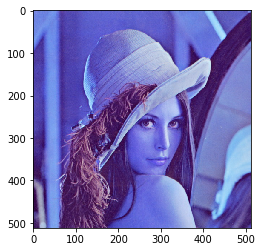

RGB Result


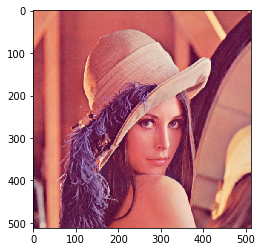

In [36]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2


## Load a colored image
BGR_img = cv2.imread(img_src)

## display image
#  images display is done by matlab commands because cv2.imshow() crashes wih colab 

# blue output :opencv reads and displays an image as BGR format instead of RGB color format.
#              Whereas matplotlib uses RGB color format to display image
print("BGR Result")
plt.imshow(BGR_img)
plt.show()


#converting bgr to rgb first
RGB_img = cv2.cvtColor(BGR_img, cv2.COLOR_BGR2RGB)
print("RGB Result")
plt.imshow(np.array(RGB_img))
plt.show()

## **2 Generating a black-and-white sketch**

To obtain a sketch (black-and-white drawing) of the image, we will use **an edge-detection filter**. 

Whereas to obtain a color painting, we will use **an edge-preserving filter (bilateral filter)** to further smooth the flat regions while keeping the edges intact.

By overlaying the sketch drawing on top of the color painting, we obtain a cartoon effect.

There are many different edge detection filters, such as Sobel, Scharr, Laplacian filters, or Canny-edge detector. We will use a Laplacian edge filter since it produces edges that look most similar to hand sketches compared to Sobel or Scharr, and that are quite consistent compared to a Canny-edge detector, which produces very clean line drawings but is affected more by random noise in the image.

Nevertheless, we still need to reduce the noise in the image before we use a Laplacian edge filter. We will use a **Median filter** because it is good at removing noise while keeping edges
sharp.

### **2.1 Noise Reduction Using Median Filter**

Since Laplacian filters use grayscale images, we must convert from OpenCV’s default BGR
format to Grayscale, this could be easily done using the **CvtColor()** function in OpenCV.

For noise reduction, we apply a Median filter with a 7 7 square aperture. This could be
done using the **Smooth()** function.

Grayscale Image


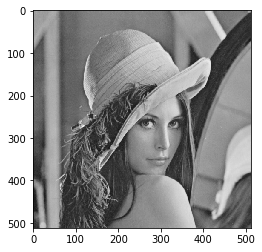

In [37]:
## convert image to grayscale

gray_img = cv2.cvtColor(BGR_img, cv2.COLOR_BGR2GRAY)

# display grayscale image
print("Grayscale Image")
plt.imshow(gray_img,  cmap='gray', vmin=0, vmax=255)
plt.show()


Grayscale Image


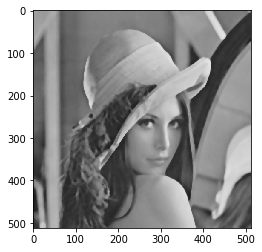

In [38]:
## Noise reduction on grayscale image

#  Median filter

median_gray_img = cv2.medianBlur(gray_img,7)


# display grayscale image
print("Grayscale Image")
plt.imshow(median_gray_img,  cmap='gray', vmin=0, vmax=255)
plt.show()


### **2.2 Edge Detection Using Laplacian Filter**

After noise reduction, a **Laplacian filter** of aperture size = 5 is used for edge detection.

Laplacian Filter


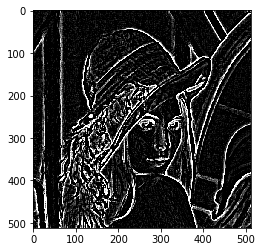

In [32]:
## Apply Laplacian filter

# Desired depth of the destination image
ddepth = cv2.CV_16S
# Aperture size used to compute the second-derivative filters
kernel_size = 5


laplacian_img = cv2.Laplacian(median_gray_img, ddepth, ksize=kernel_size)



# display results
print("Laplacian Filter")
plt.imshow(laplacian_img,  cmap='gray', vmin=0, vmax=255)
plt.show()

The Laplacian filter produces edges with varying brightness, so to make the edges look more like a sketch we apply a binary threshold to make the edges either white or black. This could be done using **Threshold()** OpenCV function with threshold value = 125.

In [0]:
def getSobelEdge(img , size=3):
    sx = cv2.Sobel(img, cv2.CV_64F,1,0,ksize=size)
    sy = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=size)
    edges = np.sqrt(np.square(sx) + np.square(sy))
    edges = np.floor((edges / (np.max(edges)+0.001)) * 255 ).astype(np.uint8)
    return edges

After Thresholding


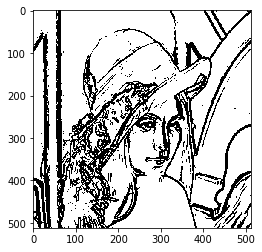

In [41]:
## Apply thresholding to the image

# creating the mask
# ret,mask = cv2.threshold(laplacian_img,125,255,cv2.THRESH_BINARY)
edges = getSobelEdge(median_gray_img , -1)
_ , mask = cv2.threshold(edges , 10 , 255 , cv2.THRESH_BINARY_INV )


# display results
print("After Thresholding")
plt.imshow(mask,  cmap='gray', vmin=0, vmax=255)
plt.show()

## **3 Generating a color painting and a cartoon**

A strong **bilateral filter** smooths flat regions while keeping edges sharp, and is therefore great as an automatic cartoonifier or painting filter, except that it is extremely slow (that is, measured in seconds or even minutes rather than milliseconds!).

We will therefore use some tricks to obtain a nice cartoonifier that still runs at an acceptable speed. The most important trick we can use is to perform bilateral filtering at a lower resolution. It will have a similar effect as at full resolution. This could be done using Resize() function for resizing the image and then applying the bilateral filter using the Smooth() function.

Rather than applying a large bilateral filter, we will apply many small bilateral filters to produce a strong cartoon effect in less time. We will truncate the filter so that instead of performing a whole filter (for example, a filter size of 21 x 21), it just uses the minimum filter size needed for a convincing result (for example, with a filter size of just 9 x 9).

We have four parameters that control the bilateral filter: color strength, positional strength, size, and repetition count. Suitable values for these parameters are:

• Color strength: 9

• Positional strength: 7

• Size: 9

• Repetition count: 7

Then we can overlay the edge mask that we found earlier. To overlay the edge mask “sketch” onto the bilateral filter “painting”, we can start with a black background and copy the “painting” pixels that aren’t edges in the “sketch” mask. This could also be done using the And() OpenCV function.

(512, 512, 3)
Cartoonified Image Result


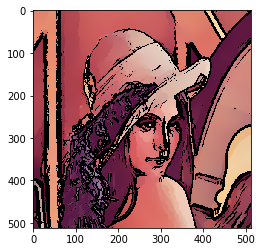

In [42]:
# trick:-
# perform bilateral filtering at a lower resolution
# therefore if the number of pixels is more than : 400 * 400
# reduce the resolution by the factor of 4
# if the resolution is below (150 * 150) : increase it by factor of 2
img = BGR_img

height , width, _ = img.shape
img = cv2.resize(img,(width//2, height//2), interpolation = cv2.INTER_LINEAR)

# four parameters that control the bilateral filter:
# color strength, positional strength, size, and repetition count

# use resizedImg instead of the img
tmp = img
# repetitions for stronger cartoon effect
REPETITIONS = 7
# filter size
ksize = 9
# Filter color strength
sigmaColor = 9
# spatial strength
sigmaSpace = 7

for i in range(REPETITIONS):
    tmp = cv2.bilateralFilter(img, ksize, sigmaColor , sigmaSpace)
    img = cv2.bilateralFilter(tmp , ksize, sigmaColor , sigmaSpace)

img = cv2.resize(img, (width, height))
newimg = np.zeros(img.shape).astype(np.uint8)
print(newimg.shape)
for i in range(3):
    newimg[:,:,i] = cv2.bitwise_and(img[:,:,i],mask)


    
## display results    
print("Cartoonified Image Result")
plt.imshow(cv2.cvtColor(newimg, cv2.COLOR_BGR2RGB))
plt.show()
